# Supervised Learning: KNN, SVM, and Logistic Regression

In this notebook, we attempted various supervised machine learning techniques. They are as such:
- KNN Classifier
- SVM Classifier
- Logistic Regression 

This included running the default model, employing hyperparameter optimisation, and testing the optimised model.

**Conclusions from this notebook:**

We will be using Logistic Regression in our final model as it offered the best scores (recall, f1 and accuracy) and it is predictable and scalable. 

## Imports

In this section, we load all the packages required to run the notebook.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    cross_validate,
)
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

## Read in train dataset

In this section:
- We load the training data, and look at first 5 values and shape. This data has already been cleaned, processed and new features created.
- Separate the data into X-train (features) and y-train (output)
- Use Oversampling (SMOTE) technique to create a balanced training data-set

In [2]:
# Load data from excel
api_df = pd.read_excel("../../data/processed/preprocessed_train.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# X, y split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
y_train.value_counts()

Medium    661
Low       651
High        4
Name: Risk_Label, dtype: int64

In [6]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors=k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [7]:
# Balance training data
X_train, y_train = create_smote(X_train, y_train, 2)

# Helper Code

In this section, we provide helper code that is used in the subsequent sections for evaluating the models. The function `mean_std_cross_val_scores()` computes the train score and test score for the `scoring_metric` using sklearn's `cross_validate()`. The final scores are returned in `results` dictionary.

In [8]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [9]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Baseline Performance

In this section, we evaluate the baseline score for the following models model on the evaluation metrics given in `scoring_metric`:
- Dummy Classifier
- KNN Classifier
- SVM Classifier
- Logistic Regression

The baseline model performance is obtained before hyper-parameter optimization and without any feature selection.

### Dummy Classifier Model

In [10]:
model_dummy = DummyClassifier(strategy="stratified", random_state=42)
results["Dummy"] = mean_std_cross_val_scores(
    model_dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy
fit_time,0.005 (+/- 0.006)
score_time,0.009 (+/- 0.002)
test_accuracy,0.342 (+/- 0.019)
train_accuracy,0.331 (+/- 0.010)
test_f1_macro,0.342 (+/- 0.019)
train_f1_macro,0.331 (+/- 0.010)
test_recall_macro,0.342 (+/- 0.019)
train_recall_macro,0.331 (+/- 0.010)


### KNN Classifier Model

In [11]:
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
results["KNN"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN
fit_time,0.005 (+/- 0.006),0.018 (+/- 0.003)
score_time,0.009 (+/- 0.002),0.063 (+/- 0.011)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.012)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.012)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.012)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003)


### SVM Classifier Model

In [12]:
pipe_svm = make_pipeline(StandardScaler(), SVC(gamma=0.01))
results["SVM"] = mean_std_cross_val_scores(
    pipe_svm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM
fit_time,0.005 (+/- 0.006),0.018 (+/- 0.003),0.066 (+/- 0.012)
score_time,0.009 (+/- 0.002),0.063 (+/- 0.011),0.040 (+/- 0.006)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002)


### Logistic Regression Classifier Model

In [13]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["LR"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR
fit_time,0.005 (+/- 0.006),0.018 (+/- 0.003),0.066 (+/- 0.012),0.076 (+/- 0.021)
score_time,0.009 (+/- 0.002),0.063 (+/- 0.011),0.040 (+/- 0.006),0.013 (+/- 0.003)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000)


## Hyperparameter Optimization

In this section, we tune the hyper-parameters of the KNN classifier model and the Logistic Regression model.

### Hyperparameter search for KNN

In this section, we tune the `n_neighbors` parameter for KNN model using GridSearch algorithm. The range of values used for tuning are: from 5 to 500 in steps of 5. It is observed that the difference between train-test score is minimum at n_neighbors = 20. So, this is selected as the optimum value.

In [14]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(5, 500, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std()) 

results_df = pd.DataFrame(results_dict)

<AxesSubplot:xlabel='n_neighbors'>

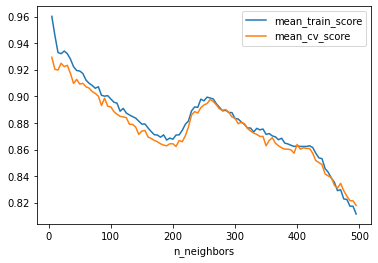

In [15]:
results_df.plot(x="n_neighbors", y=["mean_train_score", "mean_cv_score"])

In [16]:
results_df["train_cv_diff"] = results_df["mean_train_score"] - results_df["mean_cv_score"]
results_df.head(20)

,n_neighbors,mean_train_score,mean_cv_score,std_cv_score,std_train_score,train_cv_diff
0,5,0.960161,0.929386,0.016092,0.003021,0.030776
1,10,0.945789,0.920309,0.014126,0.007081,0.025480
2,15,0.932930,0.919813,0.009672,0.002338,0.013117
3,20,0.932048,0.924859,0.005405,0.005156,0.007188
4,25,0.934065,0.922334,0.011248,0.002972,0.011730
5,30,0.932046,0.923353,0.013363,0.005998,0.008693
6,35,0.928013,0.917299,0.010968,0.002959,0.010714
7,40,0.922341,0.909737,0.014698,0.006149,0.012604
8,45,0.919440,0.912764,0.011518,0.002936,0.006677
9,50,0.919062,0.909230,0.013421,0.004083,0.009832


### Hyperparameter search for LogisticRegression

In this section, we tune the `C` value and `solver` parameter for Logistic Regression model using GridSearchCV algorithm.

In [17]:
param_grid = {"logisticregression__C": [100, 10, 1.0, 0.1, 0.01],
              "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear']}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=20, n_jobs=-1, return_train_score=True
)
results_gs = grid_search.fit(X_train, y_train)

In [18]:
grid_search.best_score_

0.9954646464646466

In [19]:
grid_search.best_params_

{'logisticregression__C': 1.0, 'logisticregression__solver': 'newton-cg'}

## Performance of Optimized Models

In this section, we evaluate the performance of optimized KNN and Logistic Regression classifier models and compare the `results` to baseline models.

### KNN classifier

In [20]:
k = 20
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
results["KNN_tuned"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned
fit_time,0.005 (+/- 0.006),0.018 (+/- 0.003),0.066 (+/- 0.012),0.076 (+/- 0.021),0.013 (+/- 0.005)
score_time,0.009 (+/- 0.002),0.063 (+/- 0.011),0.040 (+/- 0.006),0.013 (+/- 0.003),0.057 (+/- 0.012)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003),0.852 (+/- 0.019)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000),0.878 (+/- 0.009)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003),0.851 (+/- 0.020)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000),0.878 (+/- 0.009)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003),0.852 (+/- 0.019)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000),0.878 (+/- 0.009)


### Logistic Regression Classifier Model

In [21]:
pipe_lr_tuned = make_pipeline(StandardScaler(), 
                              LogisticRegression(C=100.0, solver='liblinear'))
results["LR_tuned"] = mean_std_cross_val_scores(
    pipe_lr_tuned, X_train, y_train,
    return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned,LR_tuned
fit_time,0.005 (+/- 0.006),0.018 (+/- 0.003),0.066 (+/- 0.012),0.076 (+/- 0.021),0.013 (+/- 0.005),0.124 (+/- 0.021)
score_time,0.009 (+/- 0.002),0.063 (+/- 0.011),0.040 (+/- 0.006),0.013 (+/- 0.003),0.057 (+/- 0.012),0.015 (+/- 0.004)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003),0.852 (+/- 0.019),0.993 (+/- 0.006)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000),0.878 (+/- 0.009),0.998 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003),0.851 (+/- 0.020),0.993 (+/- 0.006)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000),0.878 (+/- 0.009),0.998 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.012),0.981 (+/- 0.006),0.995 (+/- 0.003),0.852 (+/- 0.019),0.993 (+/- 0.006)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.002),0.999 (+/- 0.000),0.878 (+/- 0.009),0.998 (+/- 0.001)


## Test Set Prediction

In this section, we predict the the risk labels for test data.For the purpose of running this notebook, the test data has already been processed and stored in the `data/processed/` folder. We use the `logistic regression` model obtained after hyper-parameter tuning for making the final predictions.

In [22]:
# X, y split for test-set
test_df = pd.read_excel("../../data/processed/preprocessed_test.xlsx")
X_test, y_test = test_df.drop(columns=["Risk_Label"]), test_df["Risk_Label"]

In [23]:
pipe_lr_tuned.fit(X_train, y_train)
y_pred = pipe_lr_tuned.predict(X_test)
pipe_lr_tuned.score(X_test, y_test)

1.0